# **Analyzing and Generating Scientific Abstracts**

## **Introduction**

This project explores how Large Language Models (LLMs) can be applied to the analysis and generation of scientific abstracts, using data from the arXiv repository. With the growing volume of scientific publications, LLMs offer the potential to automate abstract and title generation, saving time for researchers. Key tasks include generating titles from abstracts, generating abstracts from titles, and predicting paper categories. The dataset, available on HuggingFace, allows us to test the model's performance and refine it using cross-validation and optimization techniques.

## **Use Case**

The use case for this project is to help researchers and academics in the scientific community to generate abstracts and titles for their papers. This can be useful for researchers who are looking to quickly generate abstracts for their papers or for students who are looking to learn how to write abstracts. Additionally, the model can be used to predict paper categories, which can help researchers to quickly identify papers that are relevant to their research.

## **Scope**

This project aims to explore some of the capabilities of NLP models in generating scientific abstracts and titles, taking advantage of the arXiv dataset in order to do that. This way, we aim to provide a tool capable of:

- Generating abstracts from titles;
- Generating titles from abstracts;
- Classifying papers into categories based on their abstracts and/or titles;
- Otimizing the model's performance improving the generated titles, abstracts and categories;

## **Objectives**

The main objectives of this project are:

- Develop a tool capable of generating abstracts and titles using LLMs;
- Develop a model capable of predicting paper categories based on their abstracts and/or titles;
- Apply cross-validation to evaluate the model's accuracy, recall and F1-score;
- Improve the model's performance using, for example, alredy existing pre trained models (e.g. BERT, GPT, etc) and fine-tuning them with the arXiv dataset.
- EExperiment with summarization models available on HuggingFace and compare their performance.
- Analyze the arXiv category structure, propose a hierarchical taxonomy, and implement classification models to assess performance across different levels of this taxonomy.

## **Tasks**

The tasks involved in this project include:

1. **Dataset Analysis**: Analyze the arXiv dataset to understand its structure, metadata, and the distribution of categories. Identify the most relevant features for title generation, abstract generation, and category prediction.

2. **Data Preparation**: Preprocess the data for model training and evaluation (e.g., handling missing data, tokenization, train-test split). Create proper datasets for each task (title generation, abstract generation, and classification).

3. **Baseline Model Development**: Develop baseline models for generating abstracts and titles and for predicting paper categories using basic architectures like Seq2Seq or LSTM. Evaluate the models’ performance using standard metrics (e.g., BLEU, ROUGE, F1).

4. **Fine-tuning Pre-trained Models**: Use pre-trained models (e.g., BERT, GPT, T5) and fine-tune them on the arXiv dataset for the tasks of abstract generation, title generation, and category prediction. Evaluate improvements over baseline models.

5. **Model Optimization**: Optimize the models through hyperparameter tuning (e.g., learning rate, optimizer choice, number of layers) and by using techniques like early stopping or data augmentation. Consider experimenting with a wider subset of the arXiv dataset.

6. **Parameter Tuning for Generation Tasks**: Play with different parameter configurations (e.g., temperature, top-k, top-p) in the title and abstract generation tasks. Compare results to determine optimal settings for quality output.

7. **Experiment with Summarization Models**: Test and compare various summarization models from the HuggingFace library (e.g., BART, T5) for abstract generation. Evaluate their performance against metrics like ROUGE and BLEU.

8. **Category Prediction and Taxonomy Analysis**: Analyze existing arXiv categories and develop a hierarchical taxonomy. Train models for both flat classification and hierarchical classification. Evaluate performance using metrics like F1-score at different levels of the taxonomy.

9. **Cross-Validation and Model Evaluation**: Apply cross-validation to evaluate model robustness. Focus on metrics like accuracy, precision, recall, and F1-score to assess classification models, and BLEU/ROUGE for generation tasks.

## **Data Analysis**

The dataset contains 1999486 rows and 10 columns. The columns are as follows:

- id: Unique identifier of the ArXiv paper;
- submitter: Name of the user who submitted the paper;
- authors: Authors of the paper;
- title: Title of the paper;
- comments: Additional comments added to the paper;
- journal-ref: Identifier of the journal where the paper was submitted;
- doi: Persistent address for the paper;
- abstract: Abstract of the paper;
- report-no: Unique identifier of the paper within the organization;
- categories: Categories associated with the paper.
- versions: Version of the paper.

In order to analyse the most relevant attributes and how they interact with each other, extracting relevant information from the dataset, we will take advantage of the libraries **pandas** and **ydata_profiling**. These libraries provide a simple way to manipulate and profile datasets and extract relevant information from them.

In [ ]:
import pandas as pd

# Load the data
db = pd.read_csv("abstracts_trimmed.csv")

# Remove all columns except the abstract, title and categories
db = db[["abstract", "title", "categories"]]

In [ ]:
from ydata_profiling import ProfileReport

# Generate the Report
profile = ProfileReport(db,title="Adult Census Profile")

In [ ]:
profile

# **Predicting Paper Titles from Abstracts**

As long as the training is concered, we tried two different approaches. A first one, where we chose to split the data between training and evaluation in a more “fixed” way, randomly sampling 20% for test, and 80% for training, a slightly different approach from the more common 30-70 which proved to be better results than the latter:

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import AdamW
from datasets import load_dataset

We start by defining our device, and using the **datasets** lib to load and sample 1% of the original dataset, in order to speed the training process.

In [ ]:
device = "mps"

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small", pad_token_id=tokenizer.eos_token_id).to(device)

# Load the dataset
dataset = load_dataset("gfissore/arxiv-abstracts-2021", split="train[:1%]")  # Load only 1% of the dataset
df = dataset.to_pandas()

We must also define a class to be used by the refered lib to help handle the data

In [ ]:
# Define Dataset class
class TitleSummarizationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': self.targets['input_ids'][idx]
        }


After that, we devide the dataset into training and testing as described before:

In [ ]:
# Continue with the rest of your code
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

We then convert the dataframe into a dictionary of mappings between inputs and targets, and generate the embeddings.

In [ ]:
# Preprocess data
def preprocess_data(dataframe):
    training_data = []
    for _, row in dataframe.iterrows():
        training_data.append({
            'input': row['abstract'],
            'target': row['title']
        })
    return training_data

# Process training and testing data
training_data = preprocess_data(train_df)
testing_data = preprocess_data(test_df)

train_inputs = tokenizer([item['input'] for item in training_data], return_tensors="pt", padding=True, truncation=True).to(device)
train_targets = tokenizer([item['target'] for item in training_data], return_tensors="pt", padding=True, truncation=True).to(device)
test_inputs = tokenizer([item['input'] for item in testing_data], return_tensors="pt", padding=True, truncation=True).to(device)
test_targets = tokenizer([item['target'] for item in testing_data], return_tensors="pt", padding=True, truncation=True).to(device)

# Create datasets and dataloaders
train_dataset = TitleSummarizationDataset(train_inputs, train_targets)
test_dataset = TitleSummarizationDataset(test_inputs, test_targets)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

Finally, we can train and save the model:

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(3):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Save model and tokenizer
model.save_pretrained("fine_tuned_t5")
tokenizer.save_pretrained("fine_tuned_t5")

Since this model didn't give us excellent results, we decided to change the way training and testing data is sampled to use k-folds.
Also, we decided to try few-shot learning, by giving the model 10 exemples for each fold. We alto tried different epoch numbers and batches combinations.

In [ ]:
# K-Fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\nFold {fold + 1}")

    # Select few samples for few-shot learning (e.g., use only 10 samples for training in this fold)
    few_shot_train_idx = train_idx[:10]  # Change the number of samples here if needed
    train_df = df.iloc[few_shot_train_idx]
    val_df = df.iloc[val_idx]

    # Process training and validation data
    training_data = preprocess_data(train_df)
    validation_data = preprocess_data(val_df)

    train_inputs = tokenizer([item['input'] for item in training_data], return_tensors="pt", padding=True, truncation=True).to(device)
    train_targets = tokenizer([item['target'] for item in training_data], return_tensors="pt", padding=True, truncation=True).to(device)
    val_inputs = tokenizer([item['input'] for item in validation_data], return_tensors="pt", padding=True, truncation=True).to(device)
    val_targets = tokenizer([item['target'] for item in validation_data], return_tensors="pt", padding=True, truncation=True).to(device)

    # Create datasets and dataloaders
    train_dataset = TitleSummarizationDataset(train_inputs, train_targets)
    val_dataset = TitleSummarizationDataset(val_inputs, val_targets)

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Training loop
    model.train()
   
    total_loss = 0
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f'Average Training Loss for Fold {fold + 1}: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Average Validation Loss for Fold {fold + 1}: {avg_val_loss:.4f}')

# Save the model and tokenizer after the last fold
model.save_pretrained("fine_tuned_t5_kfold")
tokenizer.save_pretrained("fine_tuned_t5_kfold")

After evaluation, we conclued our model performance was quite satisfactory.
For example, our model predicted:
**Pure spinor formulation of the ten-dimensional superstring leads to manifestly supersymmetric loop amplitudes** for groundtruth **Fermionic superstring loop amplitudes in the pure spinor formalism**

Also, it performed satisfactory qualitatively-wise

![image.png](attachment:image.png)

## **Predicting Paper Abstracts from Titles**

Given its impressive abilities to generate text, we decided to try gpt2, despite being “older”

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
from tqdm import tqdm
from sklearn.model_selection import train_test_split  # Import train_test_split

Here, we decided to sample 1000 lines from the original dataset. We must be extra careful not to make padding tokens fall in the evaluation criteria, since there is such a big discrepancy between input and target character sizes.

In [ ]:
device = "mps"

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as pad_token

model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

# Load the dataset
df = pd.read_csv("abstracts_trimmed.csv",nrows=1000)

In [ ]:
class TitleAbstractGenerationDataset(Dataset):
    def __init__(self, inputs, targets, max_length=512):
        self.inputs = inputs
        self.targets = targets
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        input_ids = self.inputs['input_ids'][idx]
        attention_mask = self.inputs['attention_mask'][idx]
        labels = self.targets['input_ids'][idx]
        
        # Ensure proper padding handling
        labels = torch.tensor([
            label if mask == 1 else -100
            for label, mask in zip(labels, self.targets['attention_mask'][idx])
        ])
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
    
# Preprocess data
def preprocess_data(dataframe):
    training_data = []
    for _, row in dataframe.iterrows():
        formatted_input = f"Title: {row['title']}\nGenerate abstract:"
        training_data.append({
            'input': formatted_input,
            'target': row['abstract']
        })
    return training_data

Given the nature of this problem, we tried multiple combinations of training hyperparameters, until we achieved this final state:

In [ ]:
training_args = {
    'batch_size': 8,  
    'learning_rate': 2e-5,  
    'max_length': 512,  
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'num_epochs': 3
}

In [ ]:
# Split the dataset into training and validation sets (80-20 split)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Process training and validation data
training_data = preprocess_data(train_df)
validation_data = preprocess_data(val_df)

# Tokenize inputs and targets
train_inputs = tokenizer([item['input'] for item in training_data], return_tensors="pt", padding="max_length", truncation=True).to(device)
train_targets = tokenizer([item['target'] for item in training_data], return_tensors="pt", padding="max_length", truncation=True).to(device)
val_inputs = tokenizer([item['input'] for item in validation_data], return_tensors="pt", padding="max_length", truncation=True).to(device)
val_targets = tokenizer([item['target'] for item in validation_data], return_tensors="pt", padding="max_length", truncation=True).to(device)

# Create datasets and dataloaders
train_dataset = TitleAbstractGenerationDataset(train_inputs, train_targets)
val_dataset = TitleAbstractGenerationDataset(val_inputs, val_targets)

train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=3)

Then we can train the model:

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
total_loss = 0
for batch in tqdm(train_dataloader, desc="Training"):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(input_ids=batch['input_ids'], labels=batch['labels'], attention_mask=batch['attention_mask'])
    loss = outputs.loss
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
avg_train_loss = total_loss / len(train_dataloader)
print(f'Average Training Loss: {avg_train_loss:.4f}')

Validate it, printing the values for average loss:

In [ ]:
# Validation loop
model.eval()
total_val_loss = 0
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(input_ids=batch['input_ids'], labels=batch['labels'], attention_mask=batch['attention_mask'])
        total_val_loss += outputs.loss.item()

avg_val_loss = total_val_loss / len(val_dataloader)
print(f'Average Validation Loss: {avg_val_loss:.4f}')

And, finally, saving the model.

In [ ]:
model.save_pretrained("fine_tuned_gpt2_train_test_split")
tokenizer.save_pretrained("fine_tuned_gpt2_train_test_split")


However, we quickly realized that 	the fact that gpt2 is so much bigger in terms of parameters (137M compared to ~60M of t5) could be a disadvantage, since it normally requires a really big number of training data, and therefore, computacional power and time, to train a model with so many parameters. 

##

#### **Gpt2’s output** ####

“s. of the of. are. for. in. the. is. to. with. and. at. by. which.in.of.the. that. we.and.with.that. were. also. as. have.to., and, of, in the are, are the and arethe, to, theof,and theand, which are are and the, for, we are to thein, is, as,is, by,theandis.. We are also the in, with, that is the the a. a the , of and in are by the to and that the is and of are that,of the for and by are both.” 

We decided then to move **back to t5-small**, since not only is it faster to train, but also it is more suitable for our problem, since GPT-2 was trained for autoregressive text generation, not specifically for transforming one text format to another. 

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

class TitleAbstractDataset(Dataset):
    def __init__(self, titles, abstracts, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.titles = titles
        self.abstracts = abstracts
        self.max_length = max_length

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        # Format prompting text
        input_text = f"generate scientific abstract: {self.titles[idx]}"
        target_text = self.abstracts[idx]

        # Tokenize inputs
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Tokenize targets
        targets = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs.input_ids.squeeze(),
            'attention_mask': inputs.attention_mask.squeeze(),
            'labels': targets.input_ids.squeeze(),
        }

Here, we really had to test inumerous combinations of training hyperparameters and used the learning rate at our advantage to save the best model developed througout the different epochs

In [ ]:
def train_t5_model():
    # Initialize model and tokenizer
    model_name = "t5-small"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    
    # Device setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    model = model.to(device)
    
    # Training arguments
    training_args = {
        'batch_size': 8,
        'learning_rate': 5e-5,  
        'max_length': 512,
        'num_epochs': 5,
        'weight_decay': 0.01,
    }
    
    # Load data
    df = pd.read_csv("abstracts_trimmed.csv",nrows=100)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create datasets
    train_dataset = TitleAbstractDataset(
        train_df['title'].tolist(),
        train_df['abstract'].tolist(),
        tokenizer
    )
    
    val_dataset = TitleAbstractDataset(
        val_df['title'].tolist(),
        val_df['abstract'].tolist(),
        tokenizer
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=training_args['batch_size'],
        shuffle=True
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=training_args['batch_size']
    )
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=training_args['learning_rate'],
        weight_decay=training_args['weight_decay']
    )
    
    # Training loop
    best_val_loss = float('inf')
    for epoch in range(training_args['num_epochs']):
        # Training
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}')
        
        for batch in progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
            optimizer.step()
            optimizer.zero_grad()
            
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_loss / len(train_dataloader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc='Validating'):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                total_val_loss += outputs.loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f'Epoch {epoch+1}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model.save_pretrained("fine_tuned_t5_small")
            tokenizer.save_pretrained("fine_tuned_t5_small")
            

For this task, the prompting template is quite relevant to retrieve the best final output.

In [ ]:
def generate_abstract(title, model, tokenizer, device):
    input_text = f"generate scientific abstract: {title}"
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)
    
    outputs = model.generate(
        **inputs,
        max_length=320,
        min_length=100,  
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3,
        early_stopping=True,
        temperature=0.6,
        top_k=50,
        do_sample=True,
        repetition_penalty=1.2 
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

We then craeted a method to train and a basic I/O to test the model with cherry-picked inputs, in order to help visualize its output.

In [ ]:
def generate_abstract(title, model, tokenizer, device):
    input_text = f"generate scientific abstract: {title}"
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)
    
    outputs = model.generate(
        **inputs,
        max_length=400,
        min_length=130,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3,
        early_stopping=True,
        temperature=0.6,
        top_k=50,
        top_p=0.9,
        do_sample=True,
        repetition_penalty=1.7
    )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
model_path = "fine_tuned_t5_small"

tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

test_title = "Calculation of prompt diphoton production cross sections at Tevatron and LHC energies"
generated_abstract = generate_abstract(test_title, model, tokenizer, device)
print("\nGenerated Abstract:")
print(generated_abstract)

while True:
    print("\nEnter a title (or 'quit' to exit):")
    title = input()
    if title.lower() == 'quit':
        break
    
    abstract = generate_abstract(title, model, tokenizer, device)
    print("\nGenerated Abstract:")
    print(abstract)


As we can see, this final model is much closer to what we know as Natural Language:

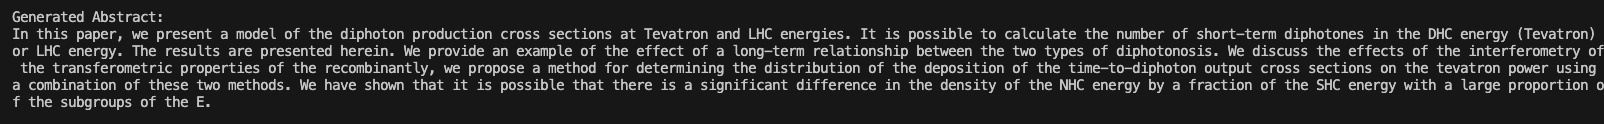

# **Predicting Paper Categories**

First we prepare the data for the classification task, converting the categories column into multiple binary columns, one for each category, and format the data.

Here we developed 2 different data preparation methods:

- One with all categories;
- One with the top N categories in order to reduce the number of classes and check if the model's performance improves.

The first one is the following:

In [ ]:
import pandas as pd

# Load the data
db = pd.read_csv("abstracts_trimmed.csv")

# Remove all columns except the abstract, title and categories
db = db[["abstract", "title", "categories"]]

In [ ]:
# Clean up characters like "[", "]", "'" from the "categories" column
db["categories"] = db["categories"].str.replace(r"[\[\]']", "", regex=True)

# Separate the "categories" column into binary columns
db = db.join(db["categories"].str.get_dummies(" "))

# Remove the "categories" column
db = db.drop(columns=["categories"])

Select a small sample of the data , otherwise the training process will be too slow.

In [ ]:
# Select the first X rows of the dataset to speed up the process
X = 100
db2 = db.tail(X)

# Save the cleaned dataset
db.to_csv("predict_dataset.csv", index=False)

# Select the first X rows of the dataset to speed up the process
X = 100
db = db.head(X)

# Save the cleaned dataset
db.to_csv("abstracts_cleaned.csv", index=False)

The second one is the following:

import pandas as pd

# Load the data
db = pd.read_csv("/content/sample_data/abstracts_trimmed.csv")

# Remove all columns except the abstract, title and categories
db = db[["abstract", "title", "categories"]]

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

# Assuming db is your original DataFrame containing the categories

# Clean up characters like "[", "]", "'" from the "categories" column
db["categories"] = db["categories"].str.replace(r"[\[\]']", "", regex=True)

# Determine the top 20 categories in the dataset
all_categories = db["categories"].str.cat(sep=' ').split()
category_counts = Counter(all_categories)
top_20_categories = [category for category, _ in category_counts.most_common(20)]

# Create an empty DataFrame to store the sampled rows
normalized_dataset = pd.DataFrame()

# Loop through each top category and sample 30 rows
for category in top_20_categories:
    # Filter rows that contain the current category
    filtered_rows = db[db["categories"].str.contains(category)]
    
    # Ensure the sampled rows contain only top 20 categories
    filtered_rows = filtered_rows[filtered_rows["categories"].str.split().apply(lambda x: all(cat in top_20_categories for cat in x))]

    # Sample 30 rows if available
    if len(filtered_rows) > 30:
        sampled_rows = filtered_rows.sample(n=30, random_state=42)
    else:
        # If less than 30 rows are available, take all of them
        sampled_rows = filtered_rows

    # Append the sampled rows to the normalized dataset
    normalized_dataset = pd.concat([normalized_dataset, sampled_rows], ignore_index=True)

# Reset the index of the normalized dataset
normalized_dataset.reset_index(drop=True, inplace=True)

# Separate the "categories" column into binary columns after normalizing
normalized_dataset = normalized_dataset.join(normalized_dataset["categories"].str.get_dummies(" "))

# Remove the "categories" column
normalized_dataset = normalized_dataset.drop(columns=["categories"])

In [ ]:
# Count the unique categories in the normalized dataset based on the binary columns
unique_categories_normalized = normalized_dataset.columns.tolist()

# Count occurrences of each unique category in the normalized dataset
normalized_category_counts = normalized_dataset[unique_categories_normalized].sum()

# Print the shape of the normalized dataset
print("Normalized Dataset Shape:", normalized_dataset.shape)

In [ ]:
# Randomly shuffle the dataset before splitting
normalized_dataset = normalized_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the dataset into 90% and 10%
train_size = int(0.9 * len(normalized_dataset))
train_dataset = normalized_dataset.iloc[:train_size]
predict_dataset = normalized_dataset.iloc[train_size:]

# Save both datasets to CSV files
train_dataset.to_csv('abstracts_cleaned.csv', index=False)
predict_dataset.to_csv('predict_dataset.csv', index=False)

# Print the shape of the datasets
print("Training Dataset Shape:", train_dataset.shape)
print("Prediction Dataset Shape:", predict_dataset.shape)

## Fine tuning a pre-trained model (BERT) to predict paper categories based on their abstracts and/or titles

In [ ]:
# Libraries to install
!pip install datasets
!pip install evaluate

### Preparing the dataset to fine-tune the model

In order to facilitate the fine-tuning process, we decided to compact all the target columns (cattegories), which corresponded to binary values, into a single column. This column is labeled as "labels" and contains a list of binary values, each one corresponding to a category (being 1 if the paper belongs to that category and 0 otherwise).

Addicionally, having in consideration that the model is supposed to predict the categories based on the abstracts and/or titles, we also substituted the "title" and "abstract" columns by a single column, labeled as "input_text", that folds each row into 3 rows with the same value in the "labels" column, but with different values in the "input_text" column (one for the title, one for the abstract and one for the concatenation of both). For this we took advantage of markers, with the objective of still identifying what text corresponds to the title and what text corresponds to the abstract. This way, one row folds in something like the following:

| labels | title | abstract |
| --- | --- | --- |
| [0, 0, ..., 1, 0] | Title of the paper | Abstract of the paper |
| ... | ... | ... |

Into something like:

| labels | input_text |
| --- | --- |
| [0, 0, ..., 1, 0] | [Title] Title of the paper [Abstract] Abstract of the paper |
| [0, 0, ..., 1, 0] | [Title] Title of the paper |
| [0, 0, ..., 1, 0] | [Abstract] Abstract of the paper |
| ... | ... |

This way, we can use the "input_text" column as the input for the model and the "labels" column as the target, facilitating the fine-tuning process.

In [ ]:
from datasets import load_dataset, DatasetDict

# First load the entire dataset
dataset = load_dataset("csv", data_files="abstracts_cleaned.csv")

# Define the category columns based on the columns in your dataset
category_columns = [col for col in dataset['train'].column_names if col not in ["title", "abstract"]]

# Create the labels column by mapping each category column into a list of binary labels
def create_labels(row):
    return [float(row[col]) for col in category_columns]

# Function to create the 3 required input text variations
def expand_rows(batch):
    titles = batch["title"]
    abstracts = batch["abstract"]
    labels_list = batch["labels"]

    input_texts = []
    labels = []

    for title, abstract, label in zip(titles, abstracts, labels_list):
        input_texts.extend([
            f"[TITLE] {title} [ABSTRACT] {abstract}",
            f"[TITLE] {title}",
            f"[ABSTRACT] {abstract}"
        ])
        # Duplicate the label for each variation
        labels.extend([label] * 3)

    return {"input_text": input_texts, "labels": labels}

# Apply the label creation and remove original category columns
dataset = dataset.map(lambda row: {'labels': create_labels(row)})
dataset = dataset.remove_columns(category_columns)

# Create the train-validation split from the original dataset
splits = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Expand rows to have 3 rows for each original row for the training set
expanded_train_dataset = splits['train'].map(expand_rows, batched=True, remove_columns=["title", "abstract"])

# Expand rows to have 3 rows for each original row for the validation set
expanded_val_dataset = splits['test'].map(expand_rows, batched=True, remove_columns=["title", "abstract"])

# Create a new DatasetDict with the desired split names
dataset = DatasetDict({
    'train': expanded_train_dataset,
    'validation': expanded_val_dataset
})

# Access the train and validation sets
train_dataset = dataset['train']
val_dataset = dataset['validation']

# Check the dataset structure
print(dataset)

# Print some basic information about the splits
print("\nTrain dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

# Print the first example from each split to verify the data
print("\nFirst example from train split:")
print(train_dataset[0])
print(train_dataset[1])
print(train_dataset[2])

print("\nFirst example from validation split:")
print(val_dataset[0])
print(val_dataset[1])
print(val_dataset[2])

Use Bert tokenizer to tokenize the input text and prepare the dataset for fine-tuning the model.

It's important to mention that we use fine tune tow different BERT models, with different sizes, so it's important to select the right tokenizer for each model.

In [ ]:
# To use the distilbert-base-uncased pre trained model after
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):

    return tokenizer(examples["input_text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Check the dataset structure
print(tokenized_datasets)

# Print the first example from each tokenized split to verify the data
print("\nFirst example from train split:")
print(tokenized_datasets['train'][0])

print("\nFirst example from validation split:")
print(tokenized_datasets['validation'][0])

In [ ]:
# To use the TinyBERT pre trained model after
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

def tokenize_function(examples):

    return tokenizer(examples["input_text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Check the dataset structure
print(tokenized_datasets)

# Print the first example from each tokenized split to verify the data
print("\nFirst example from train split:")
print(tokenized_datasets['train'][0])

print("\nFirst example from validation split:")
print(tokenized_datasets['validation'][0])

In [ ]:
# Clean up the tokenized datasets by removing the original input_text column
tokenized_datasets = tokenized_datasets.remove_columns("input_text")
tokenized_datasets = tokenized_datasets.with_format("torch")

# Access the train and validation sets
print(tokenized_datasets["train"])
print(tokenized_datasets["validation"])

### Train the model

To train the model we used 2 different strategies:

- Train the model using cross entropy as loss function;
- Train the model using weighted Binary Cross Entropy (BCE) as loss function;

Also we used both distilbert-base-uncased and huawei-noah/TinyBERT_General_4L_312D pre trained models.

Next we have both training blocks.

In [ ]:
# Using distilbert-base-uncased pre trained model
from transformers import AutoModelForSequenceClassification

num_labels = len(category_columns)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

In [ ]:
# Using TinyBERT pre trained model
from transformers import AutoModelForSequenceClassification

num_labels = len(category_columns)
model = AutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Using cross entropy as loss function:

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=1e-3,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=4,
    weight_decay=0.01
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid_logits = torch.sigmoid(torch.tensor(logits))
    threshold = 0.3
    predictions = (sigmoid_logits > threshold).numpy().astype(np.int32)
    labels = labels.astype(np.int32)
    
    accuracies = [accuracy_score(label, pred) for pred, label in zip(predictions, labels)]
    return {"accuracy": np.mean(accuracies)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)
trainer.train()

Using weighted Binary Cross Entropy (BCE) as loss function:

In [ ]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import torch.nn.functional as F

# Calculate appropriate steps based on dataset size
total_samples = len(train_dataset)
batch_size = 8
steps_per_epoch = total_samples // batch_size
warmup_steps = steps_per_epoch  # One epoch of warmup

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=warmup_steps,
    gradient_accumulation_steps=4,
    fp16=False,
    gradient_checkpointing=False,
    save_total_limit=2,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Apply sigmoid to get probabilities
    probs = 1 / (1 + np.exp(-logits))
    
    # Lower thresholds for small dataset
    thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
    best_f1 = 0
    best_threshold = 0.5
    best_predictions = None
    
    # Find the best threshold
    for threshold in thresholds:
        predictions = (probs > threshold).astype(np.int32)
        f1 = f1_score(labels, predictions, average='macro', zero_division=1)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_predictions = predictions
    
    # Calculate metrics using the best threshold
    predictions = best_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=1
    )
    accuracy = accuracy_score(labels, predictions)
    
    # Count positive predictions and actual positives
    pred_pos = predictions.sum()
    actual_pos = labels.sum()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'best_threshold': best_threshold,
        'predicted_positives': int(pred_pos),
        'actual_positives': int(actual_pos)
    }

class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Weighted BCE loss with higher weight for positive examples
        pos_weight = torch.ones_like(labels[0]).float() * 3.0
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1, logits.shape[-1]), 
                       labels.float().view(-1, labels.shape[-1]))
        
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

print(f"Training with {total_samples} samples")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Warmup steps: {warmup_steps}")
print(f"Total steps: {steps_per_epoch * training_args.num_train_epochs}")

trainer.train()

Using weighted Binary Cross Entropy (BCE) as loss function with other parameters:

In [ ]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import torch.nn.functional as F

# Calculate appropriate steps based on dataset size
total_samples = len(train_dataset)
batch_size = 8
steps_per_epoch = total_samples // batch_size
warmup_steps = steps_per_epoch

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    weight_decay=0.02,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_steps=warmup_steps,
    logging_steps=steps_per_epoch,
    gradient_accumulation_steps=4,
    fp16=True,
    gradient_checkpointing=True,
    save_total_limit=2,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Apply sigmoid to get probabilities
    probs = 1 / (1 + np.exp(-logits))
    
    # Broader range of thresholds due to more labels
    thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
    best_f1 = 0
    best_threshold = 0.5
    best_predictions = None
    
    # Find the best threshold
    for threshold in thresholds:
        predictions = (probs > threshold).astype(np.int32)
        # Use weighted average instead of macro for better handling of many labels
        f1 = f1_score(labels, predictions, average='weighted', zero_division=1)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_predictions = predictions
    
    # Calculate metrics using the best threshold
    predictions = best_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=1
    )
    accuracy = accuracy_score(labels, predictions)
    
    # Additional metrics for multi-label scenario
    label_wise_f1 = f1_score(labels, predictions, average=None, zero_division=1)
    worst_label_f1 = np.min(label_wise_f1)
    best_label_f1 = np.max(label_wise_f1)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'best_threshold': best_threshold,
        'predicted_positives': int(predictions.sum()),
        'actual_positives': int(labels.sum()),
        'worst_label_f1': float(worst_label_f1),
        'best_label_f1': float(best_label_f1)
    }

# Custom trainer class with weighted loss
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Dynamic weighting based on label frequency
        total_samples = labels.size(0) * labels.size(1)
        pos_samples = labels.sum()
        neg_samples = total_samples - pos_samples
        pos_weight = (neg_samples / pos_samples).clamp(min=1.0, max=5.0)
        
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits.view(-1, logits.shape[-1]), 
                       labels.float().view(-1, labels.shape[-1]))
        
        return (loss, outputs) if return_outputs else loss

# Initialize the trainer
trainer = MultilabelTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# Train the model
print(f"Training with {total_samples} samples")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Warmup steps: {warmup_steps}")
print(f"Total steps: {steps_per_epoch * training_args.num_train_epochs}")

trainer.train()

### Test the model to predict the categories of a new papers

In [ ]:
# Load the prediction dataset from the csv
prediction_dataset = load_dataset("csv", data_files="predict_dataset.csv")

# Apply the label creation and remove original category columns
prediction_dataset = prediction_dataset.map(lambda row: {'labels': create_labels(row)})
prediction_dataset = prediction_dataset.remove_columns(category_columns)

# Duplicate the dataset for each input text variation
prediction_dataset = prediction_dataset.map(expand_rows, batched=True, remove_columns=["title", "abstract"])

# Tokenize the prediction dataset
tokenized_prediction_dataset = prediction_dataset.map(tokenize_function, batched=True)

# Clean up the tokenized prediction dataset by removing the original input_text column
tokenized_prediction_dataset = tokenized_prediction_dataset.remove_columns("input_text")

# Access the prediction set
print("Prediction dataset:\n")
print(tokenized_prediction_dataset)

# Print the first example from the prediction set to verify the data
print("\nFirst example from prediction set:")
print(tokenized_prediction_dataset["train"][0])
print(tokenized_prediction_dataset["train"][1])
print(tokenized_prediction_dataset["train"][2])

In [ ]:
# Make predictions on the prediction set
predictions = trainer.predict(tokenized_prediction_dataset["train"])

# Process predictions if necessary
predicted_labels = predictions.predictions  # Access the predictions output
predicted_categories = (torch.sigmoid(torch.tensor(predicted_labels)) > 0.5).int().numpy()

# Function to map binary vectors to category names
def get_category_names(binary_vector, category_columns):
    return [category_columns[i] for i in range(len(binary_vector)) if binary_vector[i] == 1]

# Access the actual labels from the tokenized prediction dataset
actual_labels = tokenized_prediction_dataset['train']['labels']

total_correct_title_only = 0
total_correct_abstract_only = 0
total_correct_title_abstract = 0

total_wrong_title_only = 0
total_wrong_abstract_only = 0
total_wrong_title_abstract = 0

# Display the expected and predicted categories along with the counts
for i in range(len(predicted_categories)):
    # Get expected categories from actual labels
    expected_categories = get_category_names(actual_labels[i], category_columns)
    # Get predicted categories from predicted categories
    predicted_category_names = get_category_names(predicted_categories[i], category_columns)
    
    # Calculate correct and wrong predictions
    correct_predictions = set(expected_categories) & set(predicted_category_names)
    wrong_predictions = set(predicted_category_names) - set(expected_categories)
    num_correct = len(correct_predictions)
    num_wrong = len(wrong_predictions)

    # Check which input text variations were correctly predicted
    if i % 3 == 0:
        total_correct_title_abstract += num_correct
        total_wrong_title_only += num_wrong
    elif i % 3 == 1:
        total_correct_title_only += num_correct
        total_wrong_abstract_only += num_wrong
    else:
        total_correct_abstract_only += num_correct
        total_wrong_title_abstract += num_wrong

    print(f"Example {i}: Expected categories: {expected_categories}, Predicted categories: {predicted_category_names}")
    print(f"Correctly predicted: {num_correct}, Incorrectly predicted: {num_wrong}\n")

# Print the total correct and wrong predictions for each input text variation
print(f"Total correct predictions for title only: {total_correct_title_only}; Total wrong predictions: {total_wrong_title_only}")
print(f"Total correct predictions for abstract only: {total_correct_abstract_only}; Total wrong predictions: {total_wrong_abstract_only}")
print(f"Total correct predictions for title and abstract: {total_correct_title_abstract}; Total wrong predictions: {total_wrong_title_abstract}")